In [ ]:
# https://github.com/spmallick/learnopencv/tree/master/Keras-ImageNet-Models
# https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/

# https://github.com/spmallick/learnopencv/tree/master/Keras-Transfer-Learning
# https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

# https://github.com/spmallick/learnopencv/tree/master/Keras-Fine-Tuning
# https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
train_dir = './clean_data/train'
validation_dir = './clean_data/valid'

nTrain = 600
# Batch size needs pool of 20 from 150 w/o replacement, 
# predict statment must take same amount of samples as training batch size
# wanted 20, only got 10, 150 % 20 != 0
# Train or Test Set % batch_size == 0
nVal = 160

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 2910 images belonging to 3 classes.


In [6]:
features_batch.shape

(20, 7, 7, 512)

In [7]:
train_features.shape

(600, 25088)

In [8]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 1197 images belonging to 3 classes.


In [9]:
features_batch.shape

(20, 7, 7, 512)

In [10]:
validation_features.shape

(160, 25088)

In [11]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 600 samples, validate on 160 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 3.1327 - acc: 0.4617 - val_loss: 0.5654 - val_acc: 0.8188
Epoch 2/20
600/600 [==============================] - 1s 909us/step - loss: 0.6665 - acc: 0.7267 - val_loss: 0.0508 - val_acc: 1.0000
Epoch 3/20
600/600 [==============================] - 1s 900us/step - loss: 0.5944 - acc: 0.7633 - val_loss: 0.4430 - val_acc: 0.8563
Epoch 4/20
600/600 [==============================] - 1s 904us/step - loss: 0.4560 - acc: 0.8167 - val_loss: 0.3176 - val_acc: 0.9062
Epoch 5/20
600/600 [==============================] - 1s 905us/step - loss: 0.3647 - acc: 0.8650 - val_loss: 1.0073 - val_acc: 0.6250
Epoch 6/20
600/600 [==============================] - 1s 899us/step - loss: 0.3252 - acc: 0.8617 - val_loss: 0.8514 - val_acc: 0.6562
Epoch 7/20
600/600 [==============================] - 1s 903us/step - loss: 0.2027 - acc: 0.9217 - val_loss: 2.3075 - val_acc: 0.1750
Epoch 8/20
600/600

In [13]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [14]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [15]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 1/160


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [23]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0])

Original label:apple, Prediction :apple, confidence : 1.000


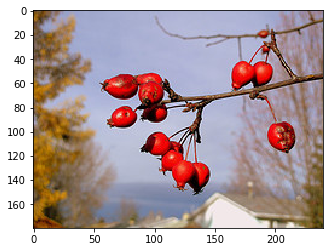

In [16]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()